In [39]:
import raster_geometry as rg
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import rotate
import pickle
import sys
sys.path.insert(0,'/home/georgeos/Documents/GitHub/SYMPTOMM2')
import itertools

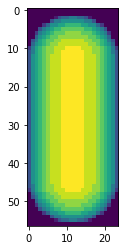

In [154]:
def raster_cell(length, width):
    radius = int(width/2)
    cyl_height = int(length - 2*radius)
    shape = 200 #200
    cylinder = rg.cylinder(
            shape = shape,
            height = cyl_height,
            radius = radius,
            axis=0,
            position=(0.5,0.5,0.5),
            smoothing=False)

    sphere1 = rg.sphere(shape,radius,((shape + cyl_height)/(2*shape),0.5,0.5))
    sphere2 = rg.sphere(shape,radius,((shape - cyl_height)/(2*shape),0.5,0.5))


    cell = (cylinder + sphere1 + sphere2)
    cell = cell[int(shape/2-cyl_height/2-radius-1):int(shape/2+cyl_height/2+radius+1),
                int(shape/2)-radius:int(shape/2)+radius,
               int(shape/2)-radius:int(shape/2)+radius]
    z,x,y = cell.nonzero()
    OPL_cell = np.sum(cell,axis=2)
    return OPL_cell

OPL_cell = raster_cell(length = 55, width=25)
plt.imshow(OPL_cell)
plt.show()

In [161]:
SYMPTOMM_to_props(cell_timeseries[400][0])

{'length': 55,
 'width': 25,
 'angle': 0.8923890768685354,
 'position': array([ 17, 542])}

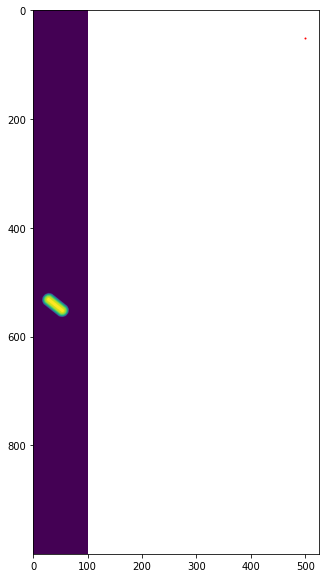

In [181]:
space = np.zeros((1000,100))
angle = np.rad2deg(0.892)
y, x = 542, 40
rotated_OPL_cell = rotate(OPL_cell,angle,resize=True,clip=False,preserve_range=True)
cell_y, cell_x = (np.array(rotated_OPL_cell.shape)/2).astype(int)
offset_y = rotated_OPL_cell.shape[0] - space[y-cell_y:y+cell_y,x-cell_x:x+cell_x].shape[0]
offset_x = rotated_OPL_cell.shape[1] - space[y-cell_y:y+cell_y,x-cell_x:x+cell_x].shape[1]
space[y-cell_y:y+cell_y+offset_y,x-cell_x:x+cell_x+offset_x] = rotated_OPL_cell
plt.figure(figsize=(20,10))
plt.imshow(space)
plt.scatter([int(space.shape[0]/2)],[int(space.shape[1]/2)],s=1,c="r")
plt.show()

In [164]:
space[y-cell_y:y+cell_y+offset_y,x-cell_x:x+cell_x+offset_x].shape

(54, 12)

In [176]:
(np.array(rotated_OPL_cell.shape)/2).astype(int)

array([27, 29])

In [175]:
space[y-cell_y:y+cell_y,x-cell_x:x+cell_x].shape[1]

0

In [180]:
cell_x

29

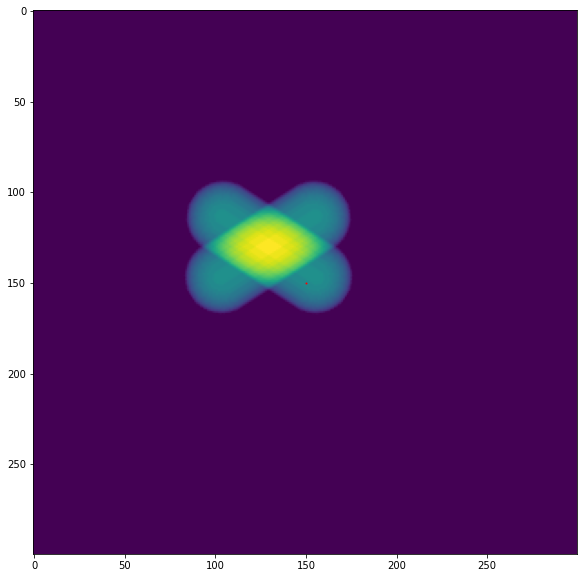

In [681]:
space = np.zeros((300,300))
place_cell(101, 40, 1, (130,130), space)
place_cell(101, 40, -1, (130,130), space)

plt.figure(figsize=(20,10))
plt.imshow(space)
plt.scatter([int(space.shape[0]/2)],[int(space.shape[1]/2)],s=1,c="r")
plt.show()

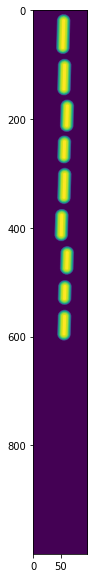

In [629]:
def SYMPTOMM_to_props(symptomm_cell, x_offset = 40):
    length = int(symptomm_cell.length)
    width = int(symptomm_cell.width)
    angle = symptomm_cell.angle - 4
    position = (np.array(symptomm_cell.position)).astype(int)
    position[0] += x_offset
    properties = {
        "length": length,
        "width": width,
        "angle": angle,
        "position": position
    }
    return properties
with open("../output_pickles/cell_timeseries.p", "rb") as f:
    cell_timeseries = pickle.load(f)
len(cell_timeseries)
cells_time = cell_timeseries[-1]
cells_time
space = np.zeros((1000,100))
for cell in cells_time:
    place_cell(space=space,**SYMPTOMM_to_props(cell))
plt.figure(figsize=(20,10))
plt.imshow(space)
plt.show()


In [632]:
import pymunk
with open("../output_pickles/space.p", "rb") as f:
    space = pickle.load(f)

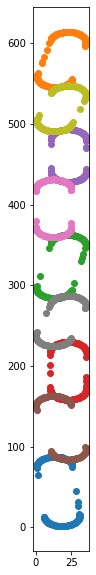

In [633]:
plt.figure(figsize=(1,10))
for body, shape in zip(space.bodies, space.shapes):
    if body.body_type == 0:
        vertices = []
        for v in shape.get_vertices():
            x,y = v.rotated(shape.body.angle) + shape.body.position #.rotated(self.shape.body.angle)
            vertices.append((x,y))
        vertices = np.array(vertices)
        
        plt.scatter(vertices[:,0], vertices[:,1])


In [712]:
def get_distance(vertex1, vertex2):
    return abs(np.sqrt((vertex1[0]-vertex2[0])**2 + (vertex1[1]-vertex2[1])**2))

def find_farthest_vertices(vertex_list):
    vertex_combs = list(itertools.combinations(vertices, 2))
    distance = 0
    farthest_vertices = 0
    for vertex_comb in vertex_combs:
        distance_ = get_distance(vertex_comb[0],vertex_comb[1])
        if distance_ > distance:
            distance = distance_
            farthest_vertices = vertex_comb
    return np.array(farthest_vertices)

def get_midpoint(vertex1, vertex2):
    x_mid = (vertex1[0]+vertex2[0])/2
    y_mid = (vertex1[1]+vertex2[1])/2
    return np.array([x_mid,y_mid])

def vertices_slope(vertex1, vertex2):
    return (vertex1[1] - vertex2[1])/(vertex1[0] - vertex2[0])

def midpoint_intercept(vertex1, vertex2):
    midpoint = get_midpoint(vertex1, vertex2)
    slope = vertices_slope(vertex1, vertex2)
    intercept = midpoint[1]-(slope*midpoint[0])
    return intercept

def get_centroid(vertices: list[tuple]) -> tuple:
    """Return the centroid of a list of vertices 
    
    Keyword arguments:
    vertices -- A list of tuples containing x,y coordinates.

    """
    return np.sum(vertices,axis=0)/len(vertices)

def place_cell(length, width, angle, position, space):
    angle = np.rad2deg(angle)
    x, y = np.array(position).astype(int)
    OPL_cell = raster_cell(length = length, width=width)
    rotated_OPL_cell = rotate(OPL_cell,angle,resize=True,clip=False,preserve_range=True)
    cell_y, cell_x = (np.array(rotated_OPL_cell.shape)/2).astype(int)
    offset_y = rotated_OPL_cell.shape[0] - space[y-cell_y:y+cell_y,x-cell_x:x+cell_x].shape[0]
    offset_x = rotated_OPL_cell.shape[1] - space[y-cell_y:y+cell_y,x-cell_x:x+cell_x].shape[1]
    space[y-cell_y+100:y+cell_y+offset_y+100,x-cell_x+100:x+cell_x+offset_x+100] += rotated_OPL_cell

In [713]:
farthest_vertices = find_farthest_vertices(vertices)

In [714]:
farthest_vertices

array([[ 26.77160001, 532.14443001],
       [  9.16304588, 478.35256281]])

In [715]:
((farthest_vertices[0][1] - farthest_vertices[1][1])/(farthest_vertices[0][0] - farthest_vertices[1][0]))

3.054871331250353

In [716]:
np.arctan(vertices_slope(farthest_vertices[0], farthest_vertices[1]))

1.254443990007476

In [717]:
get_distance(farthest_vertices[0],farthest_vertices[1])

56.60058441148022

In [718]:
midpoint = get_midpoint(farthest_vertices[0],farthest_vertices[1])

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

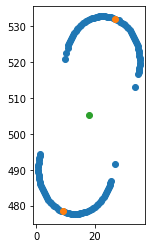

In [719]:
plt.figure(figsize=(2,4))
plt.scatter(vertices[:,0], vertices[:,1])
plt.scatter(farthest_vertices[:,0], farthest_vertices[:,1])
plt.scatter(midpoint[0], midpoint[1])
plt.plot

In [720]:
def find_vertices_above_midpoint(vertex_list):
    farthest_vertices = find_farthest_vertices(vertex_list)
    slope = vertices_slope(farthest_vertices[0],farthest_vertices[1])
    intercept = midpoint_intercept(farthest_vertices[0],farthest_vertices[1])
    above_vertices = []
    for vertex in vertex_list:
        if vertex[1] > vertex[0]*slope + intercept:
            above_vertices.append(vertex)
    return np.array(above_vertices)

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

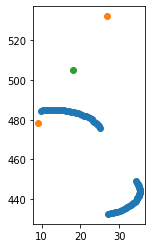

In [721]:
plt.figure(figsize=(2,4))
plt.scatter(above_vertices[:,0], above_vertices[:,1])
plt.scatter(farthest_vertices[:,0], farthest_vertices[:,1])
plt.scatter(midpoint[0], midpoint[1])
plt.plot

In [722]:
plt.figure(figsize=(1,10))
for body, shape in zip(space.bodies, space.shapes):
    if body.body_type == 0:
        vertices = []
        for v in shape.get_vertices():
            x,y = v.rotated(shape.body.angle) + shape.body.position #.rotated(self.shape.body.angle)
            vertices.append((x,y))
        vertices = np.array(vertices)
        
        plt.scatter(vertices[:,0], vertices[:,1])


AttributeError: 'numpy.ndarray' object has no attribute 'bodies'

<Figure size 72x720 with 0 Axes>

In [835]:
with open("../output_pickles/cell_timeseries.p", "rb") as f:
    cell_timeseries = pickle.load(f)
cell_timeseries_properties = []
for cell_timeseries_lists in cell_timeseries:
    cell_properties = []
    for cell in cell_timeseries_lists:
        body, shape = (cell.body, cell.shape)
        vertices = []
        for v in shape.get_vertices():
            x,y = v.rotated(shape.body.angle) + shape.body.position #.rotated(self.shape.body.angle)
            vertices.append((x,y))
        vertices = np.array(vertices)

        centroid = get_centroid(vertices) 
        farthest_vertices = find_farthest_vertices(vertices)
        length = get_distance(farthest_vertices[0],farthest_vertices[1])
        width = cell.width
        angle = np.arctan(vertices_slope(farthest_vertices[0], farthest_vertices[1]))
        cell_properties.append([length, width, angle, centroid])
    cell_timeseries_properties.append(cell_properties)

In [837]:
a = 0
for cell_properties in cell_timeseries_properties:
    space = np.zeros((800,170))
    offsets = 30
    for properties in cell_properties:
        length, width, angle, position = properties
        angle = np.rad2deg(angle) + 90
        x, y = np.array(position).astype(int) + offsets
        OPL_cell = raster_cell(length = length, width=width)
        rotated_OPL_cell = rotate(OPL_cell,angle,resize=True,clip=False,preserve_range=True)
        cell_y, cell_x = (np.array(rotated_OPL_cell.shape)/2).astype(int)
        offset_y = rotated_OPL_cell.shape[0] - space[y-cell_y:y+cell_y,x-cell_x:x+cell_x].shape[0]
        offset_x = rotated_OPL_cell.shape[1] - space[y-cell_y:y+cell_y,x-cell_x:x+cell_x].shape[1]
        space[y-cell_y:y+cell_y+offset_y,x-cell_x:x+cell_x+offset_x] += rotated_OPL_cell
    plt.figure(figsize=(3,10))
    plt.imshow(space,cmap="Greys_r")
    plt.tight_layout()
    plt.savefig("/home/georgeos/Documents/GitHub/SYMPTOMM2/OPL_renders/{}.png".format(str(a).zfill(3)))
    plt.clf()
    plt.close('all')
    a+=1